This notebook will showcase the development and implementation of a deep learning convolutional neural network to
solve a the facial expression classification problem.

# Downloading & Exploring Dataset

This model will use a dataset of 25616 facial expression images that are for training, and 6269 images for validation. There are five subdirectories, eahc one being linked to a class.

Here is a breakdown of the facial expressions directory and its subdirectories:

```
facial_expressions/
  train/
    anger/
    disgust/
    fear/
    happiness/
    neutral
    sadness/
    surprise/
  validate/
    anger/
    disgust/
    fear/
    hapiness/
    neutral
    sadness/
    surprise/
```

Imports:

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pathlib

from tensorflow import keras
from keras import layers
from keras.models import Sequential

Download the data:

In [ ]:
# dataset_url = "http://storage.googleapis.com/cp468-group1-dataset2/facial_expressions_shortened.zip"
dataset_url = "https://storage.googleapis.com/cp468-group-1/facial_expressions.zip"
data_dir = tf.keras.utils.get_file(origin=dataset_url, extract=True, archive_format='zip')
data_dir = pathlib.Path(data_dir).with_suffix('')

80224278/80224278 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Explore the data:

In [ ]:
extracted_dir = pathlib.Path(data_dir).parent / 'facial_expressions'

training_dir = extracted_dir / 'train'
validation_dir = extracted_dir / 'validation'

def count_images(directory):
  image_count = len(list(directory.glob('*/*.jpg')))
  return image_count

print(f"Training Dataset Image Count: {count_images(training_dir)}")
print(f"Validation Dataset Image Count: {count_images(validation_dir)}")

Training Dataset Image Count: 26369
Validation Dataset Image Count: 9518


Create a dataset:

In [ ]:
IMG_HEIGHT = 48
IMG_WIDTH = 48
batch_size = 32

train_dataset = tf.keras.utils.image_dataset_from_directory(
  training_dir,
  seed = 468,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = batch_size)
  #batch_size = count_images(training_dir))

validate_dataset = tf.keras.utils.image_dataset_from_directory(
  validation_dir,
  seed = 468,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = batch_size)
  #batch_size = count_images(validation_dir))

class_names = train_dataset.class_names
print(class_names)

Found 26369 files belonging to 7 classes.
Found 9518 files belonging to 7 classes.
['anger', 'disgust', 'fear', 'happiness', 'neutral', 'sadness', 'surprise']


Visualize the dataset:

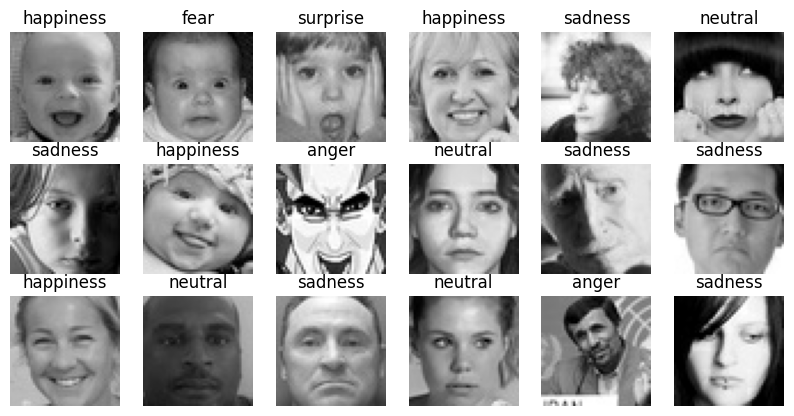

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(18):
    ax = plt.subplot(6, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Configure dataset for performance:

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validate_dataset = validate_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Standardize the data:

In [ ]:
normalization_layer = layers.Rescaling(1./255)

normalized_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_dataset))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 0.7843138


Create and compile the model:

In [ ]:
model = Sequential([
  layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_names), name="outputs")
])

model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics = ['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 48, 48, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 48, 48, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 6, 6, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ outputs (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 245,927 (960.65 KB)

 Trainable params: 245,927 (960.65 KB)

 Non-trainable params: 0 (0.00 B)

Training the model:

In [ ]:
epochs = 10

history = model.fit(
  train_dataset,
  validation_data = validate_dataset,
  epochs = epochs
)

Epoch 1/10
825/825 ━━━━━━━━━━━━━━━━━━━━ 101s 120ms/step - accuracy: 0.2962 - loss: 1.7017 - val_accuracy: 0.3059 - val_loss: 1.9020
Epoch 2/10
825/825 ━━━━━━━━━━━━━━━━━━━━ 90s 109ms/step - accuracy: 0.4439 - loss: 1.4077 - val_accuracy: 0.4049 - val_loss: 1.6703
Epoch 3/10
825/825 ━━━━━━━━━━━━━━━━━━━━ 91s 110ms/step - accuracy: 0.4966 - loss: 1.2875 - val_accuracy: 0.4142 - val_loss: 1.5694
Epoch 4/10
825/825 ━━━━━━━━━━━━━━━━━━━━ 140s 108ms/step - accuracy: 0.5411 - loss: 1.1829 - val_accuracy: 0.4495 - val_loss: 1.5467
Epoch 5/10
825/825 ━━━━━━━━━━━━━━━━━━━━ 87s 106ms/step - accuracy: 0.5738 - loss: 1.1165 - val_accuracy: 0.4697 - val_loss: 1.4557
Epoch 6/10
825/825 ━━━━━━━━━━━━━━━━━━━━ 142s 106ms/step - accuracy: 0.6039 - loss: 1.0348 - val_accuracy: 0.4622 - val_loss: 1.5497
Epoch 7/10
825/825 ━━━━━━━━━━━━━━━━━━━━ 92s 111ms/step - accuracy: 0.6206 - loss: 0.9894 - val_accuracy: 0.5083 - val_loss: 1.3646
Epoch 8/10
825/825 ━━━━━━━━━━━━━━━━━━━━ 87s 106ms/step - accuracy: 0.6468 - loss

Data visualization:

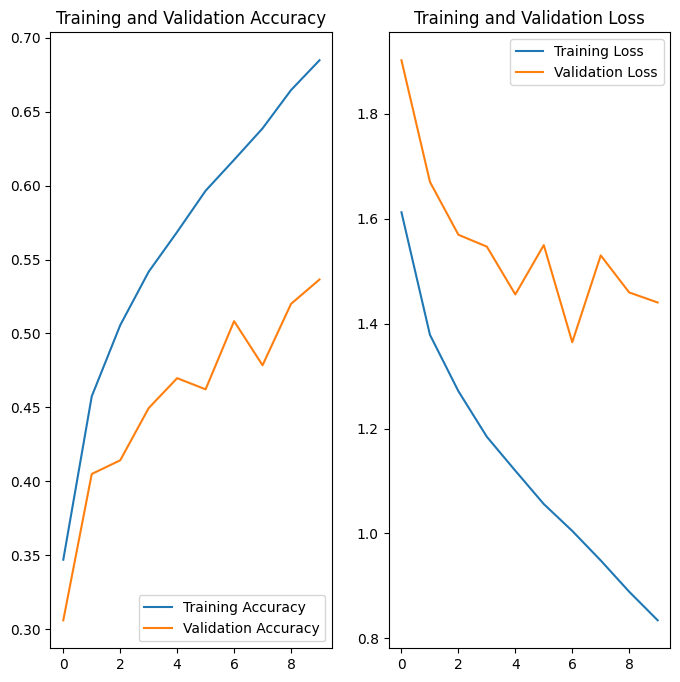

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predict on new data:

In [ ]:
test_url = "https://storage.googleapis.com/cp468-group1-dataset2/fear_test2.png"
test_path = tf.keras.utils.get_file('fear_test2.png', origin=test_url)

img = tf.keras.utils.load_img(
    test_path, target_size=(IMG_HEIGHT, IMG_WIDTH)
)


img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

2222/2222 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
This image most likely belongs to anger with a 38.73 percent confidence.


Predict on new data:

Training Dataset Image Count: 0
Found 7178 files belonging to 7 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


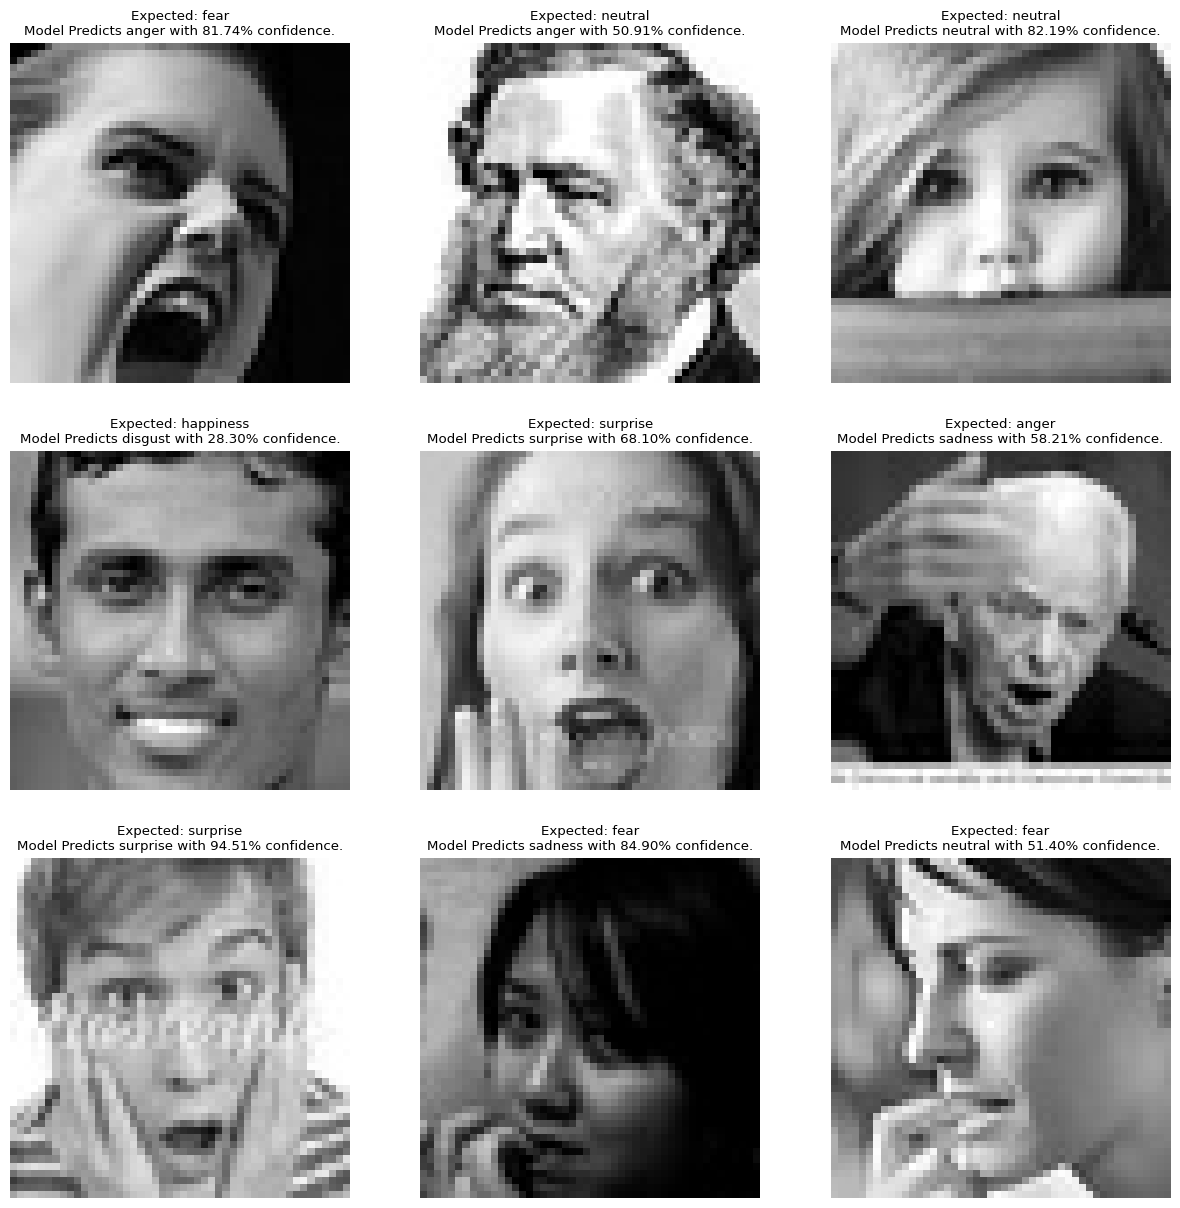

In [ ]:
testset_url = "https://storage.googleapis.com/cp468-group1-dataset2/facial_expressions_shortened.zip"
test_data_dir = tf.keras.utils.get_file(origin=testset_url, extract=True, archive_format='zip')
test_data_dir = pathlib.Path(test_data_dir).with_suffix('')

testing_dir = pathlib.Path(test_data_dir).parent / 'facial_expressions_shortened' / 'test_faces'
image_count = len(list(testing_dir.glob('*/*.png')))

print(f"Training Dataset Image Count: {image_count}")

testing_dataset = tf.keras.utils.image_dataset_from_directory(
  testing_dir,
  image_size = (IMG_HEIGHT, IMG_WIDTH),
  batch_size = batch_size)

scores = []

plt.rcParams.update({'font.size': 8})
plt.figure(figsize=(15, 15))

for images, labels in testing_dataset.take(1):

  for i in range(9):

    predictions = model.predict(images)
    scores.append(tf.nn.softmax(predictions[i]))

    prediction_text = "Expected: {}\nModel Predicts {} with {:.2f}% confidence.".format(class_names[labels[i]], class_names[np.argmax(scores[i])], 100* np.max(scores[i]))

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(prediction_text)
    plt.axis("off")